# Optimización de hiperparámetros con Algoritmos genéticos y Branch & Bound

**Dataset:** California Housing

**Autores:** Manuela Guedez Leivas y Lucía Olivera Freire

## Resumen

Este notebook contiene una implementación reproducible que compara dos estrategias para buscar hiperparámetros de un `RandomForestRegressor` sobre el dataset *California Housing*:

- **Algoritmo Genético (GA)** con elitismo, mutación y early stopping (patience).
- **Búsqueda Exhaustiva / Branch & Bound (B&B)** (aquí implementada como búsqueda sistemática con memoización; dado que no es naturalmente apto para el uso de programación dinámica, la búsqueda explora el espacio completo pero registra el progreso para comparar).

El objetivo es mostrar cómo evolucionan el *fitness* (aquí definido como `-RMSE` para poder maximizar) a lo largo de las evaluaciones de cada método y comparar resultados finales. Se incluyen celdas para instalar dependencias, preprocesamiento, funciones con documentación y visualizaciones comparativas.


## Requisitos e instalación

Ejecuta esta celda para instalar las librerías necesarias (si usas un entorno ya configurado, puedes omitirla):

In [4]:
# ejecuta en una celda de terminal o prefijo ! en una celda de Jupyter
!pip3 install --upgrade pip
!pip3 install pandas numpy scikit-learn matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 12.2 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 25.1.1
    Uninstalling pip-25.1.1:
      Successfully uninstalled pip-25.1.1
  Using cached matplotlib-3.10.7-cp313-cp313-macosx_11_0_arm64.whl.metadata (11 kB)
  Using cached contourpy-1.3.3-cp313-cp313-macosx_11_0_arm64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached kiwisolver-1.4.9-cp313-cp313-macosx_11_0_arm64.whl.metadata (6.3 kB)
  Using cached pillow-12.0.0-cp313-cp313-macosx_11_0_arm64.whl.metadata (8.8 kB)
  Using cached pyparsing-3.2.5-py3-none-any.whl.metadata (5.0 kB)
Using cached matplotlib-3.10.7-cp313-cp313-macosx_11_0_arm64.whl (8.1 MB)
Using cached contourpy-1.3.3-cp313-cp313-macosx_11_0_arm64.whl (274 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 9.5 MB/s  0:00:00m eta 0:00:01
Using cached kiwisolver-1.4.9-cp3

## 0. Imports y configuración global

In [5]:
# Imports
import itertools
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Reproducibilidad
RANDOM_STATE = 127
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

## 1. Carga y preprocesamiento

In [7]:
# Carga (asegúrate de tener 'housing.csv' en la misma carpeta o ajusta la ruta)
housing = pd.read_csv('housing.csv').dropna()

X = housing.drop(columns=['median_house_value'])
y = housing['median_house_value']

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
# Batch del 10% para evaluación rápida dentro del GA y B&B
X_train_full, X_batch, y_train_full, y_batch = train_test_split(X_train, y_train, test_size=0.1, random_state=RANDOM_STATE)

num_features = [
    'longitude', 'latitude', 'housing_median_age',
    'total_rooms', 'total_bedrooms', 'population',
    'households', 'median_income'
]
cat_features = ['ocean_proximity']

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
])


## 2. Función de evaluación (fitness)

In [8]:
def fitness_rmse(params, Xb, yb):
    """
    Evaluación del modelo con RMSE negativo (para que un mayor fitness sea mejor).

    Parameters
    ----------
    params : dict
        Hiperparámetros para RandomForestRegressor (ej: {'n_estimators':100, ...}).
    Xb : pd.DataFrame
        Features del conjunto de evaluación.
    yb : pd.Series / array
        Target del conjunto de evaluación.

    Returns
    -------
    float
        Fitness = -RMSE (valor negativo, se busca maximizar).
    """
    model = Pipeline([
        ('pre', preprocessor),
        ('rf', RandomForestRegressor(**params, random_state=RANDOM_STATE))
    ])
    model.fit(Xb, yb)
    pred = model.predict(Xb)
    rmse = np.sqrt(mean_squared_error(yb, pred))
    return -rmse

## 3. Espacio de búsqueda de hiperparámetros

In [9]:
param_space = {
    'n_estimators': [50, 100, 150, 200, 250, 300],
    'max_depth': [4, 6, 8, 10, 12, 14, None],
    'min_samples_split': [2, 4, 6, 8],
    'min_samples_leaf': [1, 2, 3, 4, 5]
}

## 4. Operadores genéticos

In [10]:
def random_params():
    """
    Genera un individuo aleatorio del espacio de hiperparámetros.

    Returns
    -------
    dict
        Hiperparámetros con valores elegidos al azar.
    """
    return {k: random.choice(v) for k, v in param_space.items()}


def mutate(params, mutation_rate=0.4):
    """
    Aplica mutación a un individuo.

    Parameters
    ----------
    params : dict
        Individuo a mutar.
    mutation_rate : float
        Probabilidad de que ocurra una mutación.

    Returns
    -------
    dict
        Nuevo individuo (posiblemente mutado).
    """
    new_params = params.copy()
    if random.random() < mutation_rate:
        key = random.choice(list(param_space.keys()))
        new_params[key] = random.choice(param_space[key])
    return new_params


def crossover(p1, p2):
    """
    Cruza dos padres y devuelve un hijo combinando aleatoriamente cada clave.

    Parameters
    ----------
    p1, p2 : dict
        Padres.

    Returns
    -------
    dict
        Hijo resultante.
    """
    return {k: random.choice([p1[k], p2[k]]) for k in param_space.keys()}

## 5. Algoritmo Genético (con historial de fitness)

In [11]:
def genetic_optimize(
    generations=100,
    population_size=40,
    elitism=0.1,
    patience=10,
    min_improvement=0.01,
    mutation_rate=0.4
):
    """
    Ejecuta un GA sencillo que devuelve el mejor individuo y la historia del mejor fitness por generación.

    Parameters
    ----------
    generations : int
        Número máximo de generaciones.
    population_size : int
        Tamaño de la población.
    elitism : float
        Fracción de la población que se conserva sin cambios.
    patience : int
        Número de generaciones sin mejora para detener temprano.
    min_improvement : float
        Mejora relativa mínima requerida para resetear patience (ej: 0.01 = 1%).
    mutation_rate : float
        Probabilidad de mutación.

    Returns
    -------
    tuple
        (best_score, best_params, history)
        - best_score : float, mejor fitness encontrado
        - best_params : dict, hiperparámetros del mejor individuo
        - history : list[float], mejor fitness por generación
    """
    population = [random_params() for _ in range(population_size)]
    best_score = -np.inf
    best_params = None
    generations_without_improvement = 0
    history = []

    for gen in range(generations):
        scores = [(fitness_rmse(p, X_batch, y_batch), p) for p in population]
        scores.sort(reverse=True, key=lambda x: x[0])
        gen_best_score, gen_best_params = scores[0]
        history.append(gen_best_score)
        print(f"[GA] Gen {gen+1} | Mejor -RMSE: {gen_best_score:.4f}")

        if best_score == -np.inf:
            best_score = gen_best_score
            best_params = gen_best_params
        else:
            improvement = (gen_best_score - best_score) / abs(best_score) if best_score != 0 else np.inf
            if improvement >= min_improvement:
                best_score = gen_best_score
                best_params = gen_best_params
                generations_without_improvement = 0
            else:
                generations_without_improvement += 1

            if generations_without_improvement >= patience:
                print(f"Early stopping en GA: sin mejora > {min_improvement*100:.1f}% en {patience} generaciones.")
                break

        # Elitismo y reproducción
        n_elite = max(1, int(population_size * elitism))
        next_gen = [p for _, p in scores[:n_elite]]
        while len(next_gen) < population_size:
            p1, p2 = random.sample(population, 2)
            child = mutate(crossover(p1, p2), mutation_rate=mutation_rate)
            next_gen.append(child)
        population = next_gen

    return best_score, best_params, history

## 6. Branch & Bound / Búsqueda Exhaustiva con registro de progreso

> Nota: el enfoque de B&B tal como se comentó en el informe no se adapta bien al tuning porque no existe una estructura de subproblemas combinables. Para comparar en forma práctica, aquí evaluamos *exhaustivamente* todas las combinaciones, pero mantenemos un historial del mejor fitness a medida que avanzamos. Esto emula la idea de "mejor solución encontrada hasta ahora" durante una búsqueda completa.

In [12]:
from itertools import product

def exhaustive_search_with_progress(param_space):
    """
    Evalúa exhaustivamente todas las combinaciones del espacio de parámetros y devuelve
    el mejor encontrado y la historia del mejor fitness tras cada evaluación.

    Parameters
    ----------
    param_space : dict
        Diccionario con listas de valores por cada hiperparámetro.

    Returns
    -------
    tuple
        (best_params, best_score, history)
        - best_params : dict, mejor configuración encontrada
        - best_score : float, mejor fitness (mayor)
        - history : list[float], mejor fitness después de cada evaluación
    """
    keys = list(param_space.keys())
    all_values = list(product(*(param_space[k] for k in keys)))
    best_score = -np.inf
    best_params = None
    history = []

    for i, vals in enumerate(all_values, 1):
        candidate = dict(zip(keys, vals))
        score = fitness_rmse(candidate, X_batch, y_batch)
        if score > best_score:
            best_score = score
            best_params = candidate
        history.append(best_score)
        if i % 50 == 0:
            print(f"[B&B] Evaluadas {i}/{len(all_values)} configuraciones | Mejor -RMSE: {best_score:.4f}")

    return best_params, best_score, history

## 7. Ejecución de ambos métodos

In [13]:
# Ajustar parámetros si se quiere ejecutar menos generaciones durante pruebas
GA_GENERATIONS = 60
GA_POPSIZE = 30

print('\n=== OPTIMIZACIÓN GENÉTICA ===')
best_ga_score, best_ga_params, ga_history = genetic_optimize(
    generations=GA_GENERATIONS,
    population_size=GA_POPSIZE,
    elitism=0.1,
    patience=15,
    min_improvement=0.005,  # 0.5% para pruebas
    mutation_rate=0.4
)

print('\n=== BÚSQUEDA EXHAUSTIVA (B&B emulado) ===')
best_bb_params, best_bb_score, bb_history = exhaustive_search_with_progress(param_space)

print('\nRESULTADOS FINALES')
print('------------------')
print(f"Mejor fitness (GA): {-best_ga_score:.4f} RMSE")
print(f"Hiperparámetros (GA): {best_ga_params}\n")
print(f"Mejor fitness (B&B): {-best_bb_score:.4f} RMSE")
print(f"Hiperparámetros (B&B): {best_bb_params}\n")

# Entrenar modelo final con la mejor configuración GA (o B&B si prefieres)
final_model = Pipeline([
    ('pre', preprocessor),
    ('rf', RandomForestRegressor(**best_ga_params, random_state=RANDOM_STATE))
])
final_model.fit(X_train, y_train)
test_rmse = np.sqrt(mean_squared_error(y_test, final_model.predict(X_test)))
print(f"RMS E en test (modelo final - GA): {test_rmse:.4f}")


=== OPTIMIZACIÓN GENÉTICA ===
[GA] Gen 1 | Mejor -RMSE: -27455.2682
[GA] Gen 2 | Mejor -RMSE: -26251.4349
[GA] Gen 3 | Mejor -RMSE: -26251.4349
[GA] Gen 4 | Mejor -RMSE: -22608.9998
[GA] Gen 5 | Mejor -RMSE: -22608.9998
[GA] Gen 6 | Mejor -RMSE: -22608.9998
[GA] Gen 7 | Mejor -RMSE: -22608.9998
[GA] Gen 8 | Mejor -RMSE: -22608.9998
[GA] Gen 9 | Mejor -RMSE: -22608.9998
[GA] Gen 10 | Mejor -RMSE: -22566.6745
[GA] Gen 11 | Mejor -RMSE: -22566.6745
[GA] Gen 12 | Mejor -RMSE: -22566.6745
[GA] Gen 13 | Mejor -RMSE: -22566.6745
[GA] Gen 14 | Mejor -RMSE: -22566.6745
[GA] Gen 15 | Mejor -RMSE: -22566.6745
[GA] Gen 16 | Mejor -RMSE: -22566.6745
[GA] Gen 17 | Mejor -RMSE: -22566.6745
[GA] Gen 18 | Mejor -RMSE: -22566.6745
[GA] Gen 19 | Mejor -RMSE: -22566.6745
Early stopping en GA: sin mejora > 0.5% en 15 generaciones.

=== BÚSQUEDA EXHAUSTIVA (B&B emulado) ===
[B&B] Evaluadas 50/840 configuraciones | Mejor -RMSE: -42774.6940
[B&B] Evaluadas 100/840 configuraciones | Mejor -RMSE: -27455.2682
[

## 8. Visualizaciones comparativas

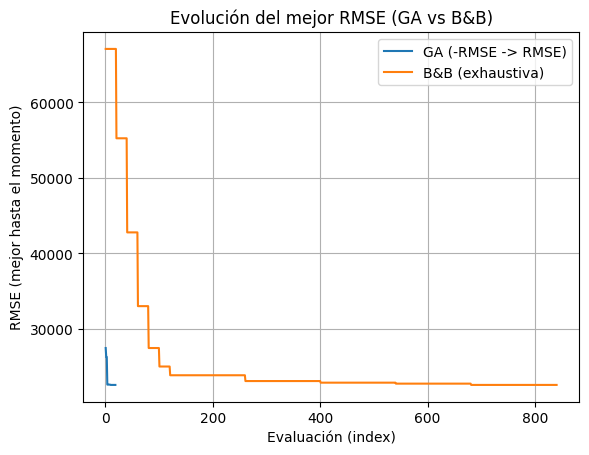

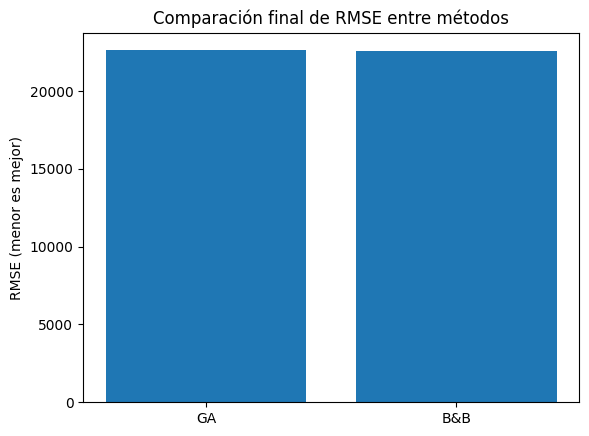

In [14]:
# 1) Evolución del mejor fitness
plt.figure()
plt.plot(range(1, len(ga_history)+1), [-v for v in ga_history], label='GA (-RMSE -> RMSE)'),
plt.plot(range(1, len(bb_history)+1), [-v for v in bb_history], label='B&B (exhaustiva)')
plt.xlabel('Evaluación (index)')
plt.ylabel('RMSE (mejor hasta el momento)')
plt.title('Evolución del mejor RMSE (GA vs B&B)')
plt.legend()
plt.grid(True)
plt.show()

# 2) Comparación final (barra)
final_rmse_ga = -best_ga_score
final_rmse_bb = -best_bb_score

plt.figure()
plt.bar(['GA', 'B&B'], [final_rmse_ga, final_rmse_bb])
plt.ylabel('RMSE (menor es mejor)')
plt.title('Comparación final de RMSE entre métodos')
plt.show()

## 9. Comentarios finales y buenas prácticas

- Cada función tiene docstrings que describen parámetros, retornos y comportamiento (resumido).
- Para notebooks reproducibles: fijar seeds, documentar celdas y reducir el dataset (batch) para pruebas rápidas.
- Atención: la búsqueda exhaustiva puede ser costosa. En este espacio de ejemplo hay 840 combinaciones (6 * 7 * 4 * 5) — dependiendo de cuánto pese el entrenamiento, la búsqueda completa puede tardar.
